## Loading dataset

In [64]:
%%time
import random
import pandas as pd
import xml.etree.ElementTree as ET

NONE_REPR = '__None__'  # representation of none word - at the beginning and end of sentence

token_list = []
lemma_list = []
pos_list = []
is_in_scope_list = []
is_negator_list = []
dist_start_list = []
dist_end_list = []
dist_comma_left_list = []
dist_comma_right_list = []
dist_neg_signal_list = []
comma_between_list = []     # is comma between current word and negation signal?
negator_pos_list = []
# neg_signal_type_list = []


def add_nan():
    token_list.append(NONE_REPR)
    token_list.append(NONE_REPR)
    lemma_list.append(NONE_REPR)
    lemma_list.append(NONE_REPR)
    pos_list.append(NONE_REPR)
    pos_list.append(NONE_REPR)
    is_in_scope_list.append(False)
    is_in_scope_list.append(False)
    is_negator_list.append(False)
    is_negator_list.append(False)
    dist_start_list.append(-1)
    dist_start_list.append(-1)
    dist_end_list.append(-1)
    dist_end_list.append(-1)
    dist_comma_left_list.append(-1)
    dist_comma_left_list.append(-1)
    dist_comma_right_list.append(-1)
    dist_comma_right_list.append(-1)
    dist_neg_signal_list.append(-1)
    dist_neg_signal_list.append(-1)
    comma_between_list.append(False)
    comma_between_list.append(False)
    negator_pos_list.append(NONE_REPR)
    negator_pos_list.append(NONE_REPR)


def find_element(sentence, text_to_find):
    for i, el in enumerate(sentence):
        if el.text == text_to_find:
            yield i


def distance_commas(token, sentence):
    commas = list(find_element(sentence, ','))
    position = sentence.getchildren().index(token)
    if len(commas) == 0:
        return -1, -1
    if position <= commas[0]:
        return 0, commas[0]
    elif position >= commas[-1]:
        return commas[-1], len(sentence)-1
    for first, second in zip(commas, commas[1:]):
        if first <= position <= second:
            return first, second


def is_in_scope(token, negator):
    if 'scope' in token.attrib.keys():
        if negator.attrib['id'] in token.attrib['scope'].split(','):
            return True
    return False


root = ET.parse('korpus_scraper/dataset-merged.xml').getroot()
sentences = root.getchildren()
random.shuffle(sentences)

for sentence in sentences:
    distance_from_end = len(sentence)
    negators = sentence.findall('./word[@negator]')
    
    for negator in negators:
        negator_position = sentence.getchildren().index(negator)
        add_nan()
    
        for step, token in enumerate(sentence):
            token_list.append(token.text)
            lemma_list.append(token.attrib['lemma'])
            pos_list.append(token.attrib['pos'])
            is_in_scope_list.append(is_in_scope(token, negator))
            is_negator_list.append(token is negator)
            dist_start_list.append(step)
            dist_end_list.append(distance_from_end - step - 1)
            left_c, right_c = distance_commas(token, sentence)
            dist_comma_left_list.append(step - left_c)
            dist_comma_right_list.append(right_c - step)
            dist_neg_signal_list.append(negator_position - step)
            comma_between_list.append(step < right_c < negator_position or negator_position < left_c < step)
            negator_pos_list.append(negator.attrib['pos'])
        
        add_nan()

df_start = pd.DataFrame.from_dict({
    'token': token_list, 
    'lemma': lemma_list, 
    'POS': pos_list, 
    'is_in_scope': is_in_scope_list,
    'is_negator': is_negator_list,
    'dist_start': dist_start_list,
    'dist_end': dist_end_list,
    'dist_comma_left': dist_comma_left_list,
    'dist_comma_right': dist_comma_right_list,
    'dist_neg_signal': dist_neg_signal_list,
    'comma_between': comma_between_list,
    'negator_pos': negator_pos_list,
})

# Split dataset into train and test sets
split = 0.75
train = df_start[:int(split*len(df_start))]
test = df_start[int(split*len(df_start)):]
X_train = train[['token', 'lemma', 'POS', 'dist_start', 'is_in_scope', 'is_negator', 'dist_end', 
                 'dist_comma_left', 'dist_comma_right', 'dist_neg_signal', 'comma_between', 'negator_pos']]
X_test = test[['token', 'lemma', 'POS', 'dist_start', 'is_in_scope', 'is_negator', 'dist_end', 
               'dist_comma_left', 'dist_comma_right', 'dist_neg_signal', 'comma_between', 'negator_pos']]
y_train = train.is_in_scope
y_test = test.is_in_scope

CPU times: user 232 ms, sys: 14.1 ms, total: 246 ms
Wall time: 286 ms


## Vectorizing

In [65]:
# Prepare sets for features
prefix_sk = {'ne', 'bez', 'pa', 'roz', 'proti', 'polo', 'tiež', 'akoby', 'trochu', 'truc', 'mimo', }
prefix_int = {'pseudo', 'i', 'in', 'anti', 'kontra', 'a', 'an', 'ex', 'non', 'kvázi', 'hypo', 'de', 'dez', 'ex', 
              'extra', }
particles = {'nie', 'figu', 'drevenú', 'figu', 'borovú', 'jalovú', 'figu', 'šušku', 'šušku', 'borovú', 'čerta', 'čerta', 
             'starého', 'čerta', 'rohatého', 'čerta', 'pekelného', 'čerta', 'ušatého', 'čerta', 'strapatého', 'paroma', 
             'paroma', 'starého', 'hroma', 'psiu', 'mater', 'horký', 'horkýtam', 'horkýže', 'horkýžetam', 'aleba', 
             'ale', 'čo', 'kde', 'kdeže', 'kdeby', 'kdežeby', 'kdežetam', 'kdežebytam', 'čo', 'čože', 'čoby', 'čožeby', 
             'ešte', 'čo', 'ešteže', 'čo', 'akurát', 'javeru', 'rozhodne', 'rovno', 'aký', 'akýže', 'akéže', }
slovak_dict = set(line.strip() for line in open('sk.dic'))


def start_with_prefix(word, prefixes):
    for p in prefixes:
        if word.startswith(p):
            return True, p
    return False, p


def detect_prefixes_and_particles(lemma):
    has_sk_prefix, p_sk = start_with_prefix(lemma, prefix_sk)
    has_int_prefix, p_int = start_with_prefix(lemma, prefix_int)
    is_particle = lemma in particles
    if has_sk_prefix:
        prefix = p_sk
    elif has_int_prefix:
        prefix = p_int
    else:
        prefix = None
    word_without_prefix_exist = False
    if prefix:
        word_without_prefix_exist = lemma[len(prefix):] in slovak_dict
    return has_sk_prefix, has_int_prefix, is_particle, word_without_prefix_exist

In [66]:
%%time
# import csv
import unicodecsv as csv
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from pos_to_features import default_values, process_pos


def add_prefix(prefix, iterable):
    for item in iterable:
        yield prefix + "_" + item


# learn training data vocabulary, then use it to create a document-term matrix
vect_lemma = CountVectorizer()
vect_lemma.fit(X_train.lemma)

# create list with the names of columns in dataframe
lemma_feat_names = list(vect_lemma.get_feature_names())
pos_feat_names = list(default_values.keys())
column_names = ['token', 'lemma', 'POS'] + \
               ['has_sk_prefix', 'has_int_prefix', 'is_particle', 
                'word_without_prefix_exist', 'start_with_ne'] + \
               ['is_in_scope', 'is_negator', 'dist_start', 'dist_end', 'dist_comma_left'] + \
               ['dist_comma_right', 'dist_neg_signal', 'comma_between'] + \
               list(add_prefix('word1', lemma_feat_names)) + \
               list(add_prefix('word2', lemma_feat_names)) + \
               list(add_prefix('word3', lemma_feat_names)) + \
               list(add_prefix('word4', lemma_feat_names)) + \
               list(add_prefix('word5', lemma_feat_names)) + \
               list(add_prefix('word1', pos_feat_names)) + \
               list(add_prefix('word2', pos_feat_names)) + \
               list(add_prefix('word3', pos_feat_names)) + \
               list(add_prefix('word4', pos_feat_names)) + \
               list(add_prefix('word5', pos_feat_names)) + \
               list(add_prefix('negator', pos_feat_names))


def create_features_list(dataframe):
    feautures_list = []
    for index, row in dataframe.iterrows():
        if index >= dataframe.iloc[-4].name:
            break
        # Prefixes + Particles
        prefices_and_particles = np.array(detect_prefixes_and_particles(dataframe.loc[index+2]['lemma']))
        # LEMMA
        dtm_lemma1 = vect_lemma.transform([row['lemma']])
        dtm_lemma2 = vect_lemma.transform([dataframe.loc[index+1]['lemma']])
        dtm_lemma3 = vect_lemma.transform([dataframe.loc[index+2]['lemma']])
        dtm_lemma4 = vect_lemma.transform([dataframe.loc[index+3]['lemma']])
        dtm_lemma5 = vect_lemma.transform([dataframe.loc[index+4]['lemma']])
        # POS
        dtm_pos1 = list(process_pos(row['POS']).values())
        dtm_pos2 = list(process_pos(dataframe.loc[index+1]['POS']).values())
        dtm_pos3 = list(process_pos(dataframe.loc[index+2]['POS']).values())
        dtm_pos4 = list(process_pos(dataframe.loc[index+3]['POS']).values())
        dtm_pos5 = list(process_pos(dataframe.loc[index+4]['POS']).values())
        negator_pos = list(process_pos(row['negator_pos']).values())
        all_things = np.concatenate([
            [dataframe.loc[index+2]['token'],
             dataframe.loc[index+2]['lemma'],
             dataframe.loc[index+2]['POS']],
            prefices_and_particles,
            [dataframe.loc[index+2]['is_in_scope'],
             dataframe.loc[index+2]['is_negator'],
             dataframe.loc[index+2]['dist_start'],
             dataframe.loc[index+2]['dist_end'],
             dataframe.loc[index+2]['dist_comma_left'],
             dataframe.loc[index+2]['dist_comma_right'],
             dataframe.loc[index+2]['dist_neg_signal'],
             dataframe.loc[index+2]['comma_between']],
            dtm_lemma1.toarray()[0],
            dtm_lemma2.toarray()[0],
            dtm_lemma3.toarray()[0],
            dtm_lemma4.toarray()[0],
            dtm_lemma5.toarray()[0],
            dtm_pos1,
            dtm_pos2,
            dtm_pos3,
            dtm_pos4,
            dtm_pos5,
            negator_pos,
        ])
        feautures_list.append(all_things)
    return feautures_list


def save_to_csv(filename, header_row, feautures_list):
    with open(filename, 'wb') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_MINIMAL)
        wr.writerow(header_row)
        for row in feautures_list:
            wr.writerow(row)

CPU times: user 68.8 ms, sys: 2.4 ms, total: 71.2 ms
Wall time: 185 ms


In [67]:
%%time

# First we transform data into lists
X_train_features_list = create_features_list(X_train)
X_test_features_list = create_features_list(X_test)

CPU times: user 1min 35s, sys: 6.94 s, total: 1min 42s
Wall time: 2min 1s


In [68]:
%%time

# Now we save our data to csv files
save_to_csv('train_scope.csv', column_names, X_train_features_list)
save_to_csv('test_scope.csv', column_names, X_test_features_list)

CPU times: user 46.4 s, sys: 9.05 s, total: 55.5 s
Wall time: 1min 3s


## Training

In [69]:
%%time

# Load dataset
df_train = pd.read_csv('train_scope.csv')
df_test = pd.read_csv('test_scope.csv')

CPU times: user 31.2 s, sys: 3.8 s, total: 35 s
Wall time: 38.2 s


In [70]:
df2_train = df_train[df_train.columns.difference(['token', 'lemma', 'POS', 'is_in_scope', 'negator_pos', 'negator_chybny_zapis'])]
df2_test = df_test[df_test.columns.difference(['token', 'lemma', 'POS', 'is_in_scope', 'negator_pos', 'negator_chybny_zapis'])]

In [58]:
df2_train
df2_train.columns[df2_train.isnull().any()].tolist()

[]

In [39]:
df2_train.loc[:, df2_train.isnull().any()]

,negator_chybny_zapis
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


In [71]:
%%time
# Import Library of Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC

# model = MultinomialNB()
model = GaussianNB()
# model = BernoulliNB()
# model = SVC()

# Train the model using the training sets 
model.fit(df2_train, df_train.is_in_scope)

CPU times: user 8.02 s, sys: 3.81 s, total: 11.8 s
Wall time: 14.9 s


## Metrics

In [72]:
from sklearn import metrics

y_pred = model.predict(df2_test)
y_true = df_test.is_in_scope

print('Accuracy: {}'.format(metrics.accuracy_score(y_true, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_true, y_pred)))
print('Recall: {}'.format(metrics.recall_score(y_true, y_pred)))
print('F1 score: {}'.format(metrics.f1_score(y_true, y_pred)))

print(metrics.classification_report(y_true, y_pred))

Accuracy: 0.9791505791505791
Precision: 1.0
Recall: 0.34146341463414637
F1 score: 0.5090909090909091
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      2508
          1       1.00      0.34      0.51        82

avg / total       0.98      0.98      0.97      2590



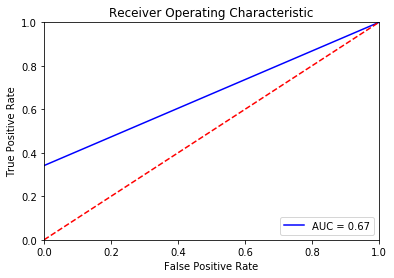

In [73]:
import matplotlib.pyplot as plt

fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
# Grid Search for Algorithm Tuning
from sklearn.model_selection import GridSearchCV
# prepare a range of alpha values to test
alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0])
# create and fit a ridge regression model, testing each alpha
model = MultinomialNB()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid.fit(df2_train, df_train.is_negation)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

/Users/jozefg/.virtualenvs/neg/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


/Users/jozefg/.virtualenvs/neg/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


/Users/jozefg/.virtualenvs/neg/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e+00,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04,   0.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
0.957593123209
1.0


## Playground

In [53]:
y_train[5]
new[5]

array([0, 0, 0, ..., 0, 0, 0])

In [56]:
#Predict Output 
predicted = model.predict([new[2]])
print(predicted)

[0]


In [87]:
from itertools import chain
from timeit import timeit


def bla1():
    c = chain(
        add_prefix("word1", lemma_feat_names), 
        add_prefix("word2", lemma_feat_names), 
        add_prefix("word3", lemma_feat_names), 
        add_prefix("word4", lemma_feat_names),
        add_prefix("word5", lemma_feat_names),
    )
    return list(c)


def bla2():
    return list(add_prefix("word1", lemma_feat_names)) + \
           list(add_prefix("word2", lemma_feat_names)) + \
           list(add_prefix("word3", lemma_feat_names)) + \
           list(add_prefix("word4", lemma_feat_names)) + \
           list(add_prefix("word5", lemma_feat_names))


print(timeit('bla1()', globals=globals(), number=1000))
print(timeit('bla2()', globals=globals(), number=1000))

6.6219878520059865


6.410430869989796
